# RBM Training using CD-1

In [137]:
import numpy as np
from scipy.special import expit
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm_notebook
from os import listdir
from random import shuffle
%matplotlib inline

In [298]:
# load training images
horizontal_dir = "striche/training/horizontal"
vertical_dir = "striche/training/vertikal"
def format_pixels(pixels):
    pixels[pixels > 0] = 1
    return pixels
horizontal = [(format_pixels(imread(horizontal_dir+"/"+imfile, mode="L").flatten()), "horizontal") for imfile in listdir(horizontal_dir)]
vertical =   [(format_pixels(imread(vertical_dir+"/"+imfile, mode="L").flatten()), "vertical") for imfile in listdir(vertical_dir)]
training = horizontal + vertical
shuffle(training)

In [320]:
# network: 100x100 visible units, 10 hidden units, 2 visible units (coding for line orientation)
n_visible = 100*100
n_hidden = 10
n_coding = 2
n_steps = 1000 # no. of CD-1 iterations
learning_rate = 1e-4
def sample_visible(hidden_states, visible_to_hidden, visible_biases):
    visible_membranes = np.array([np.dot(weights, hidden_states) for weights in visible_to_hidden.T]) \
                + visible_biases
    visible_states = np.random.binomial(1, expit(visible_membranes))
    #print 'visible:', visible_membranes, visible_states
    return visible_states

def sample_hidden(visible_states, coding_states, visible_to_hidden, coding_to_hidden, hidden_biases):
    hidden_m1 = np.array([np.dot(weights, visible_states) for weights in visible_to_hidden])
    hidden_m2 = np.array([np.dot(weights, coding_states) for weights in coding_to_hidden])
    hidden_membranes = hidden_m1 + hidden_m2 + hidden_biases
    hidden_states = np.random.binomial(1, expit(hidden_membranes))
    #print 'hidden: ', hidden_membranes, hidden_states
    return hidden_states

def sample_coding(hidden_states, coding_to_hidden, coding_biases):
    coding_membranes = np.array([np.dot(weights, hidden_states) for weights in coding_to_hidden.T]) \
                + coding_biases
    return np.random.binomial(1, expit(coding_membranes))

def train_rbm(inital_parameters):
    visible_to_hidden, coding_to_hidden, visible_biases, hidden_biases, coding_biases = inital_parameters
    errors = []
    
    probs = []
    for pixels, orientation in training:
        for i in tqdm_notebook(range(n_steps)):
            if orientation == "horizontal":
                coding_states = [0, 1]
            else:
                coding_states = [1, 0]
            # sample hidden states based on visible units 
            hidden_states = sample_hidden(pixels, coding_states, \
                                          visible_to_hidden, coding_to_hidden, hidden_biases) 
            # sample visible states based on sampled hidden states
            visible_states = sample_visible(hidden_states, visible_to_hidden, visible_biases)
            coding_states_resample = sample_coding(hidden_states, coding_to_hidden, coding_biases)
            reconstruction_error = np.sqrt(np.sum(visible_states - pixels)**2  \
                + np.sum(coding_states_resample - coding_states)**2)
            errors.append(reconstruction_error)
            hidden_m1 = np.array([np.dot(weights, visible_states) for weights in visible_to_hidden])
            hidden_m2 = np.array([np.dot(weights, coding_states) for weights in coding_to_hidden])
            hidden_membranes = hidden_m1 + hidden_m2 + hidden_biases
            probs.append(expit(hidden_membranes))
           # plt.figure()
           # plt.imshow(np.reshape(visible_states, (100, 100)))
            # resample hidden states
            hidden_states_resample = sample_hidden(visible_states, coding_states_resample, \
                                          visible_to_hidden, coding_to_hidden, hidden_biases) 
            # update weights & biases 
            #print np.shape(np.outer(pixels, hidden_states)), np.shape(np.outer(visible_states, hidden_states_resample))
            visible_to_hidden += learning_rate*(np.outer(hidden_states, pixels) \
                                                - np.outer(hidden_states_resample, visible_states))
            coding_to_hidden += learning_rate*(np.outer(hidden_states, coding_states) \
                                              - np.outer(hidden_states_resample, coding_states_resample))
            visible_biases += learning_rate*(pixels - visible_states)
            hidden_biases += learning_rate*(hidden_states - hidden_states_resample)
            coding_biases += learning_rate*(coding_state - coding_states_resample)
        #plt.figure(figsize=(15,10))
        #plt.imshow(probs)
        #plt.colorbar()
    print 'Learning results:'
    plt.figure(figsize=(15,10))
    plt.plot(errors)
    plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Reconstruction Error (Wrong pixels)")
    plt.figure(figsize=(15,10))
    plt.hist(visible_to_hidden.flatten())
    plt.xlabel("Visible-to-Hidden Weights")
    plt.figure(figsize=(15,10))
    plt.hist(coding_to_hidden.flatten())
    plt.xlabel("Coding-to-Hidden Weights")
    plt.figure(figsize=(15,10))
    plt.hist(visible_biases.flatten())
    plt.xlabel("Visible Biases")
    plt.figure(figsize=(15,10))
    plt.hist(hidden_biases.flatten())
    plt.xlabel("Hidden Biases")
    plt.figure(figsize=(15,10))
    plt.hist(coding_biases.flatten())
    plt.xlabel("Coding Biases")
    return (visible_to_hidden, coding_to_hidden, visible_biases, hidden_biases, coding_biases)


Learning results:


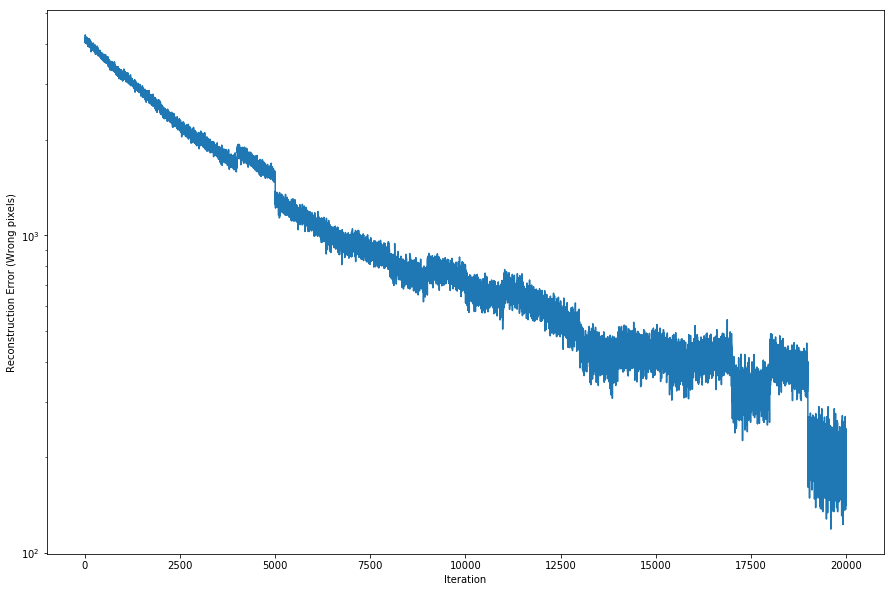

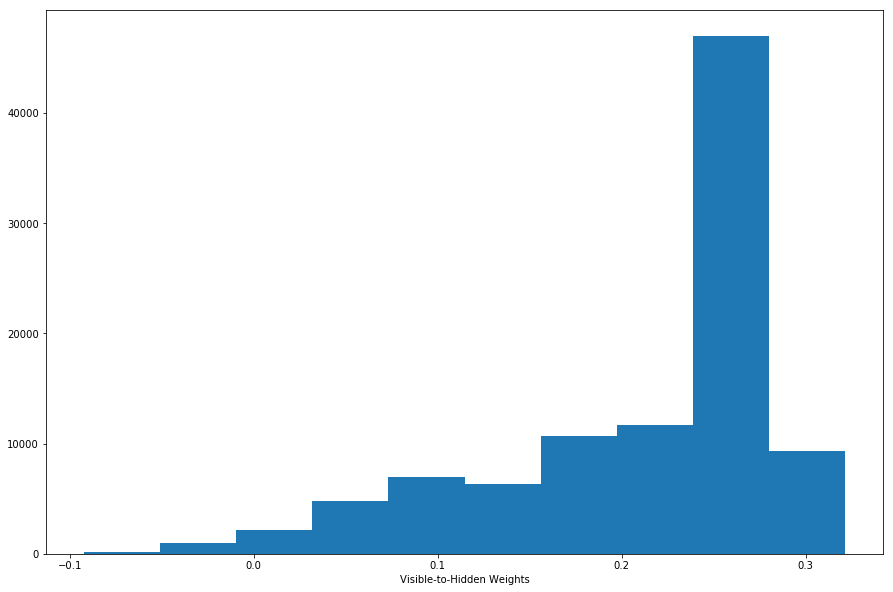

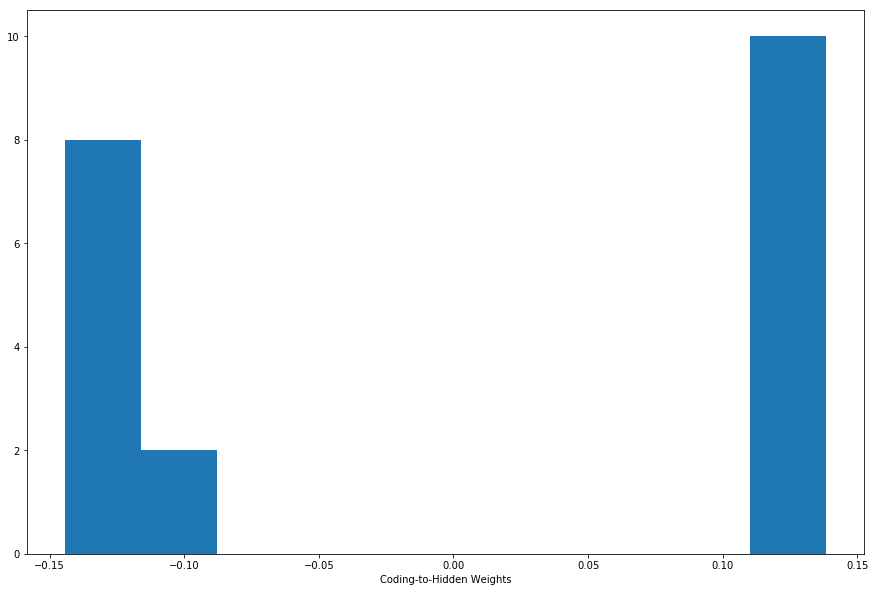

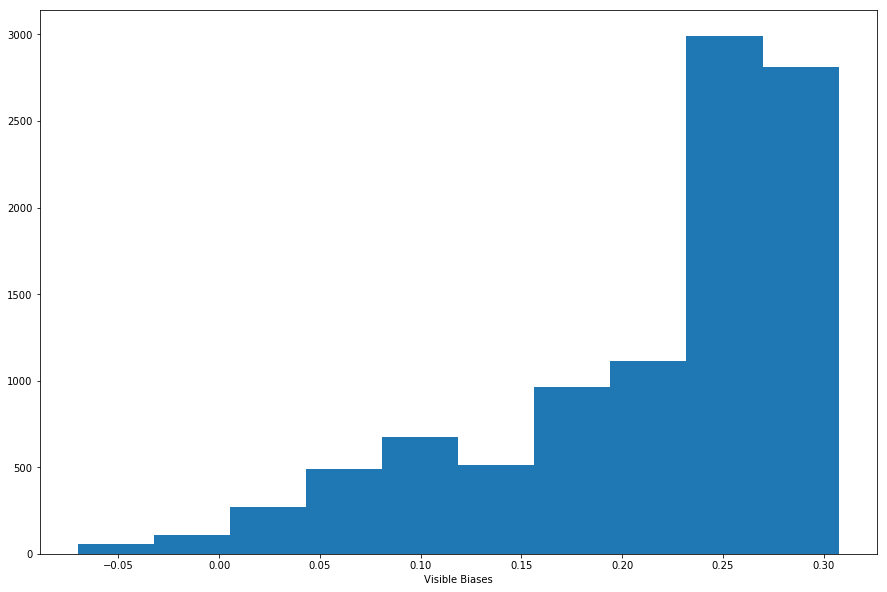

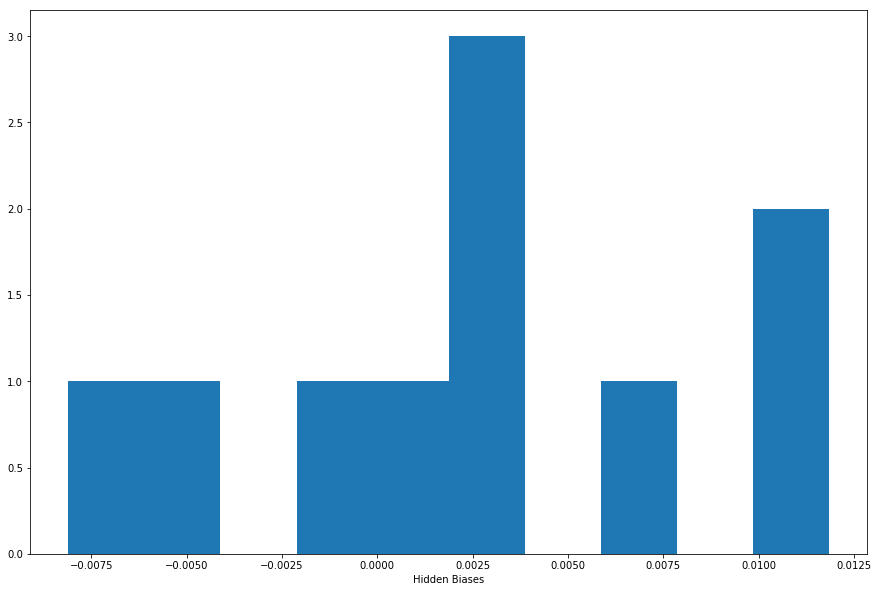

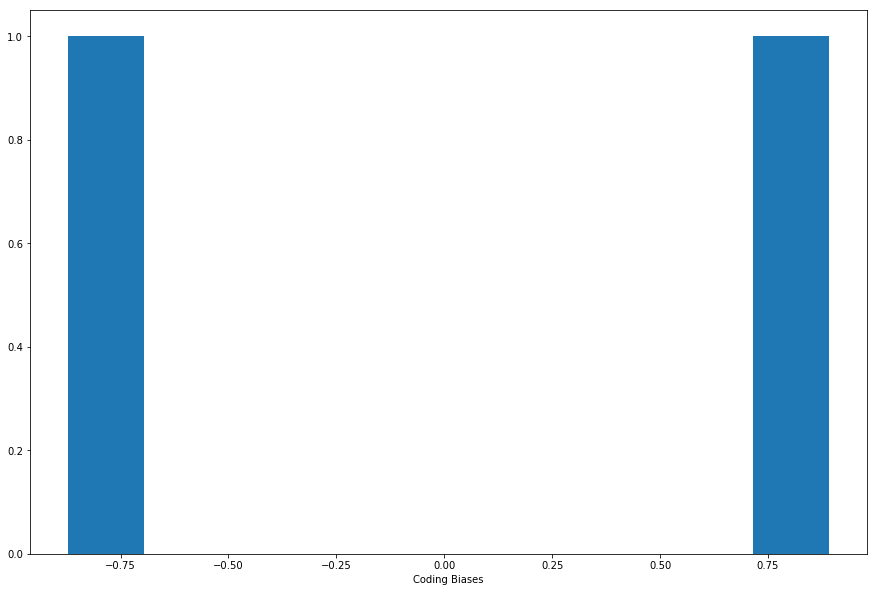

In [321]:
visible_to_hidden = np.array([np.random.normal(scale=0.01, size=n_visible) for _ in range(n_hidden)])
coding_to_hidden = np.array([np.random.normal(scale=0.01, size=n_coding) for _ in range(n_hidden)])
visible_biases = np.random.normal(scale=0.01, size=n_visible)
hidden_biases = np.random.normal(scale=0.01, size=n_hidden)
coding_biases = np.random.normal(scale=0.01, size=n_coding)
trained_parameters = train_rbm((visible_to_hidden, coding_to_hidden, visible_biases, hidden_biases, coding_biases))

In [289]:
def generate(coding_state, parameters):
    # run RBM with coding units clamped
    fig = plt.figure(figsize=(15, 10))
    visible_to_hidden, coding_to_hidden, visible_biases, hidden_biases, coding_biases = parameters
    n = int(1e3) # no. of gibbs sampling steps
    visible = np.ones(n_visible)
    hidden = np.ones(n_hidden)
    for _ in tqdm_notebook(range(n)):
        visible = sample_visible(hidden, visible_to_hidden, visible_biases)
        hidden = sample_hidden(visible, coding_state, \
                                          visible_to_hidden, coding_to_hidden, hidden_biases) 
    plt.figure(figsize=(15,10))
    plt.imshow(np.reshape(visible, (100, 100)))

def show_vertical():
    # produce image of network dreaming of vertical line
    dream([1, 0])
    
def discriminate(pixels, parameters):
    # run RBM with pixel units clamped
    visible_to_hidden, coding_to_hidden, visible_biases, hidden_biases, coding_biases = parameters
    n = int(1e3) # no. of gibbs sampling steps
    hidden = np.zeros(n_hidden)
    coding = np.zeros(n_coding)
    hist = []
    for _ in tqdm_notebook(xrange(n)):
        hidden = sample_hidden(pixels, coding, visible_to_hidden, coding_to_hidden, hidden_biases)
        coding = sample_coding(hidden_states, coding_to_hidden, coding_biases)
        hist.append(coding[0]+2*coding[1])
    plt.hist(hist)
    #print hist

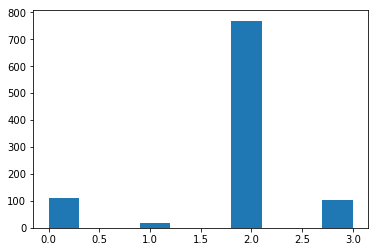

In [269]:
discriminate(training[2][0], trained_parameters)

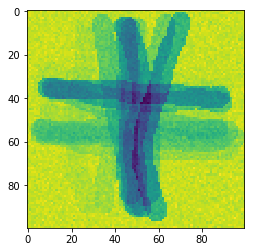

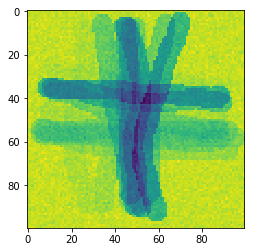

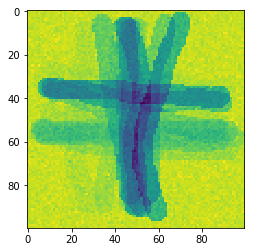

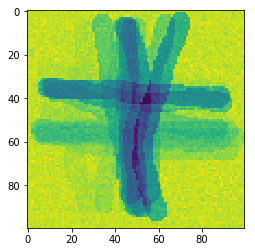

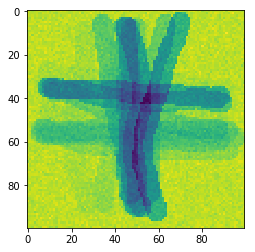

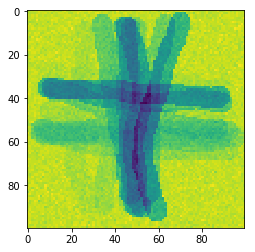

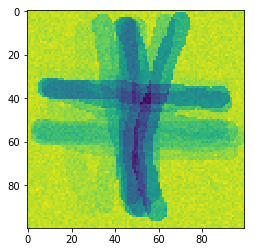

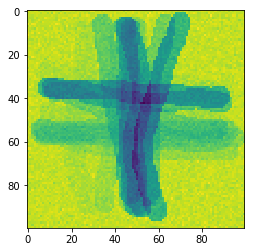

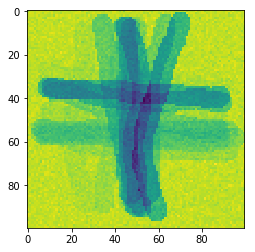

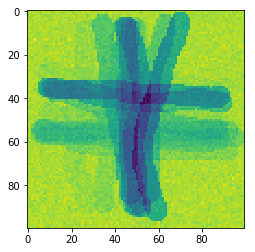

In [322]:
for i in range(n_hidden):
    plt.figure()
    plt.imshow(np.reshape(trained_parameters[0][i], (100, 100)))

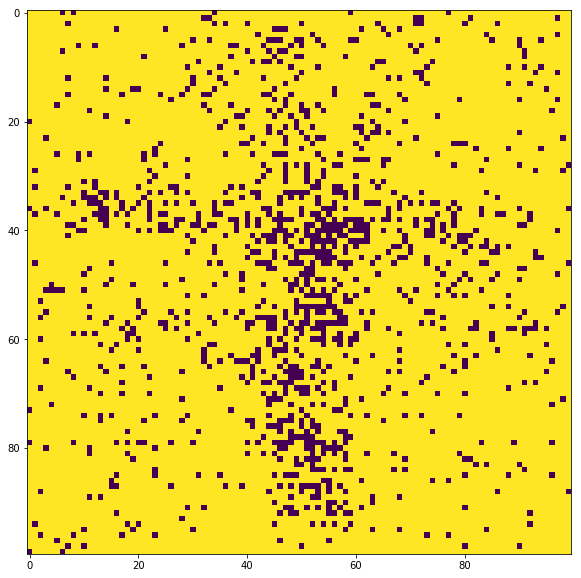

In [323]:
generate([1,0], trained_parameters)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


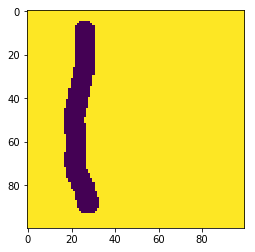

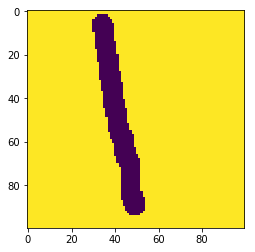

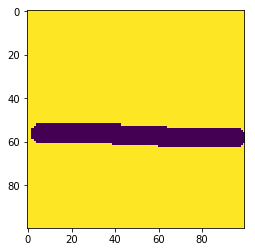

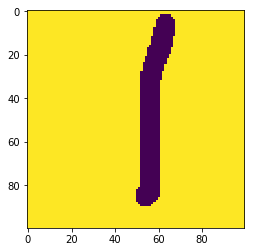

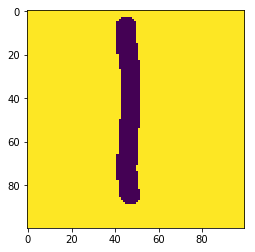

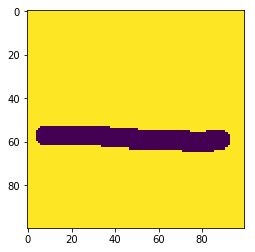

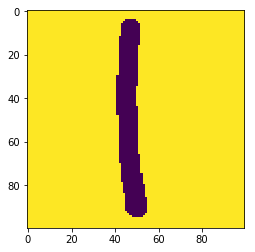

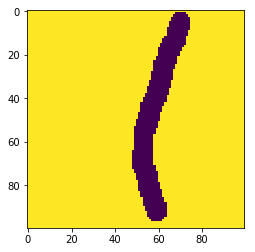

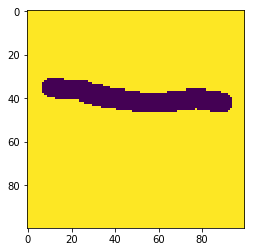

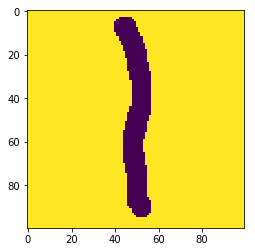

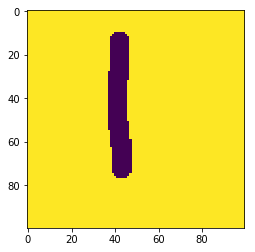

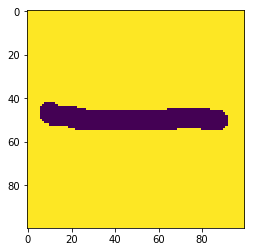

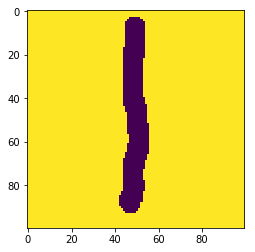

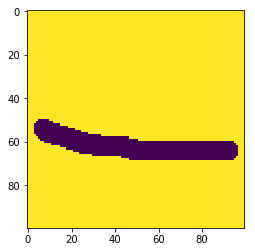

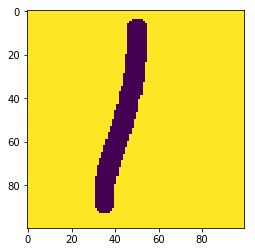

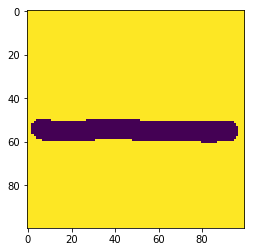

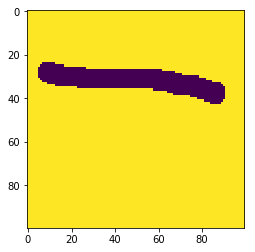

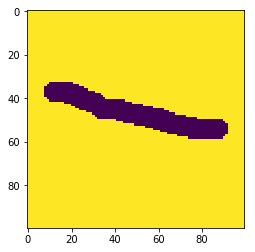

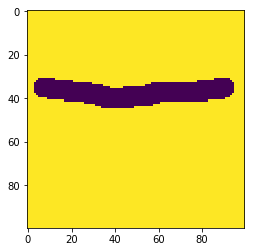

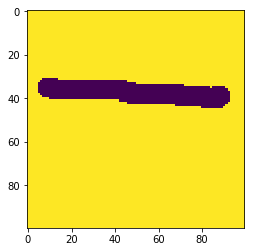

In [268]:
for i in range(20):
    plt.figure()
    print i
    plt.imshow(np.reshape(training[i][0], (100, 100)))

In [284]:
np.random.binomial(1, [1,1])

array([1, 1])